# 밑바닥부터 트랜스포머 훈련하기

> **Note:** 이 장에서는 분산 인프라에서 대규모 언어 모델을 훈련하기 위한 대용량 데이터셋과 스크립트를 만듭니다.  
> 따라서 이 노트북의 모든 단계가 코랩이나 캐글 같은 플랫폼에서 실행 가능한 것은 아닙니다.  
> 중요 지점에서 단계를 축소하거나 분산 훈련 스크립트를 만들 때 참고용으로 이 노트북을 사용하세요. 

> **Note:** 이 책의 다른 코드와 달리 이 장의 훈련 코드는 다중 GPU에서 스크립트로 실행하도록 만들어졌습니다. CodeParrot을 직접 훈련하려면  트랜스포머스 저장소([https://oreil.ly/ZyPPR](https://oreil.ly/ZyPPR))에 있는 스크립트를 사용하는 것이 좋습니다.

# 목차
### 1. 대규모 데이터셋 수집하기
### 2. 토크나이저 구축하기
### 3. 밑바닥부터 모델을 훈련하기

## 대규모 데이터셋 수집하기

### 대규모 말뭉치 구축의 어려움

사전 학습 코퍼스로 자주 사용되는 Bookcorpus와 C4 조차도 아래와 같은 품질 이슈가 있다고 합니다.
1. C4 코퍼스의 상당 부분이 기계 번역 코퍼스
2. C4의 불용어 필터링으로 아프리카계 미국인의 영어가 다수 삭제되어 관련 컨텐츠 부족
3. 민감한 컨텐츠가 그대로 담겨 있거나, 혹은 아예 삭제해버리는 경우가 있어 둘 사이 절충의 어려움
4. BookCorpus는 저작권을 위반하는 내용이 상당수
5. BookCorpus는 특정 장르에 편향

전처리 코드 예시: https://github.com/bigscience-workshop/data-preparation

In [1]:
from transformers import pipeline, set_seed

generation_gpt = pipeline("text-generation", model="openai-gpt")
generation_gpt2 = pipeline("text-generation", model="gpt2")

ModuleNotFoundError: No module named 'transformers'

In [ ]:
# 모델 파라미터 수 계산
def model_size(model):
    return sum(t.numel() for t in model.parameters())

print(f"GPT  크기: {model_size(generation_gpt.model)/1000**2:.1f}M parameters")
print(f"GPT2 크기: {model_size(generation_gpt2.model)/1000**2:.1f}M parameters")

GPT  size: 116.5M parameters
GPT2 size: 124.4M parameters


In [ ]:
set_seed(1)

In [ ]:
# 프롬트를 주고 모델이 생성하는 텍스트 관찰
def enum_pipeline_ouputs(pipe, prompt, num_return_sequences):
    out = pipe(prompt, num_return_sequences=num_return_sequences,
               clean_up_tokenization_spaces=True)
    return "\n".join(f"{i+1}." + s["generated_text"] for i, s in enumerate(out))

prompt = "\nWhen they came back"
print("GPT 자동 완성:\n" + enum_pipeline_ouputs(generation_gpt, prompt, 3))
print("")
print("GPT-2 자동 완성:\n" + enum_pipeline_ouputs(generation_gpt2, prompt, 3))

GPT completions:
1.
When they came back.
 " we need all we can get, " jason said once they had settled into the back of
the truck without anyone stopping them. " after getting out here, it 'll be up
to us what to find. for now
2.
When they came back.
 his gaze swept over her body. he 'd dressed her, too, in the borrowed clothes
that she 'd worn for the journey.
 " i thought it would be easier to just leave you there. " a woman like
3.
When they came back to the house and she was sitting there with the little boy.
 " don't be afraid, " he told her. she nodded slowly, her eyes wide. she was so
lost in whatever she discovered that tom knew her mistake

GPT-2 completions:
1.
When they came back we had a big dinner and the other guys went to see what
their opinion was on her. I did an hour and they were happy with it.
2.
When they came back to this island there had been another massacre, but he could
not help but feel pity for the helpless victim who had been left to die, and
that they had 

### 사용자 정의 코드 데이터셋 만들기

#### 구글 빅쿼리로 데이터셋 만들기
1. bigquery-public-data에서 github_repos 사용
2. github_repos에 있는 files, contents, licenses 테이블 합치기
3. binary파일 필터링 & .py 확장자만 필터링 & 1MB 보다 큰 파일 필터링

In [2]:
SQL = """
SELECT
    f.repo_name, f.path, c.copies, c.size, c.content, l.license
FROM
    `bigquery-public-data.github_repos.files` AS f
JOIN
    `bigquery-public-data.github_repos.contents` AS c
ON
    f.id = c.id
JOIN
    `bigquery-public-data.github_repos.licenses` AS l
ON
    f.repo_name = l.repo_name
WHERE
    NOT c.binary
    AND ((f.path LIKE '%.py')
        AND (c.size BETWEEN 1024
            AND 104875))
"""

- BigQuery GUI 작업 공간: https://console.cloud.google.com/bigquery?project=large-scale-tf&ws=!1m0
- BigQuery Python API: https://cloud.google.com/bigquery/docs/reference/libraries?hl=ko#client-libraries-resources-python
- BigQuery CLI: https://cloud.google.com/bigquery/docs/bq-command-line-tool?hl=ko

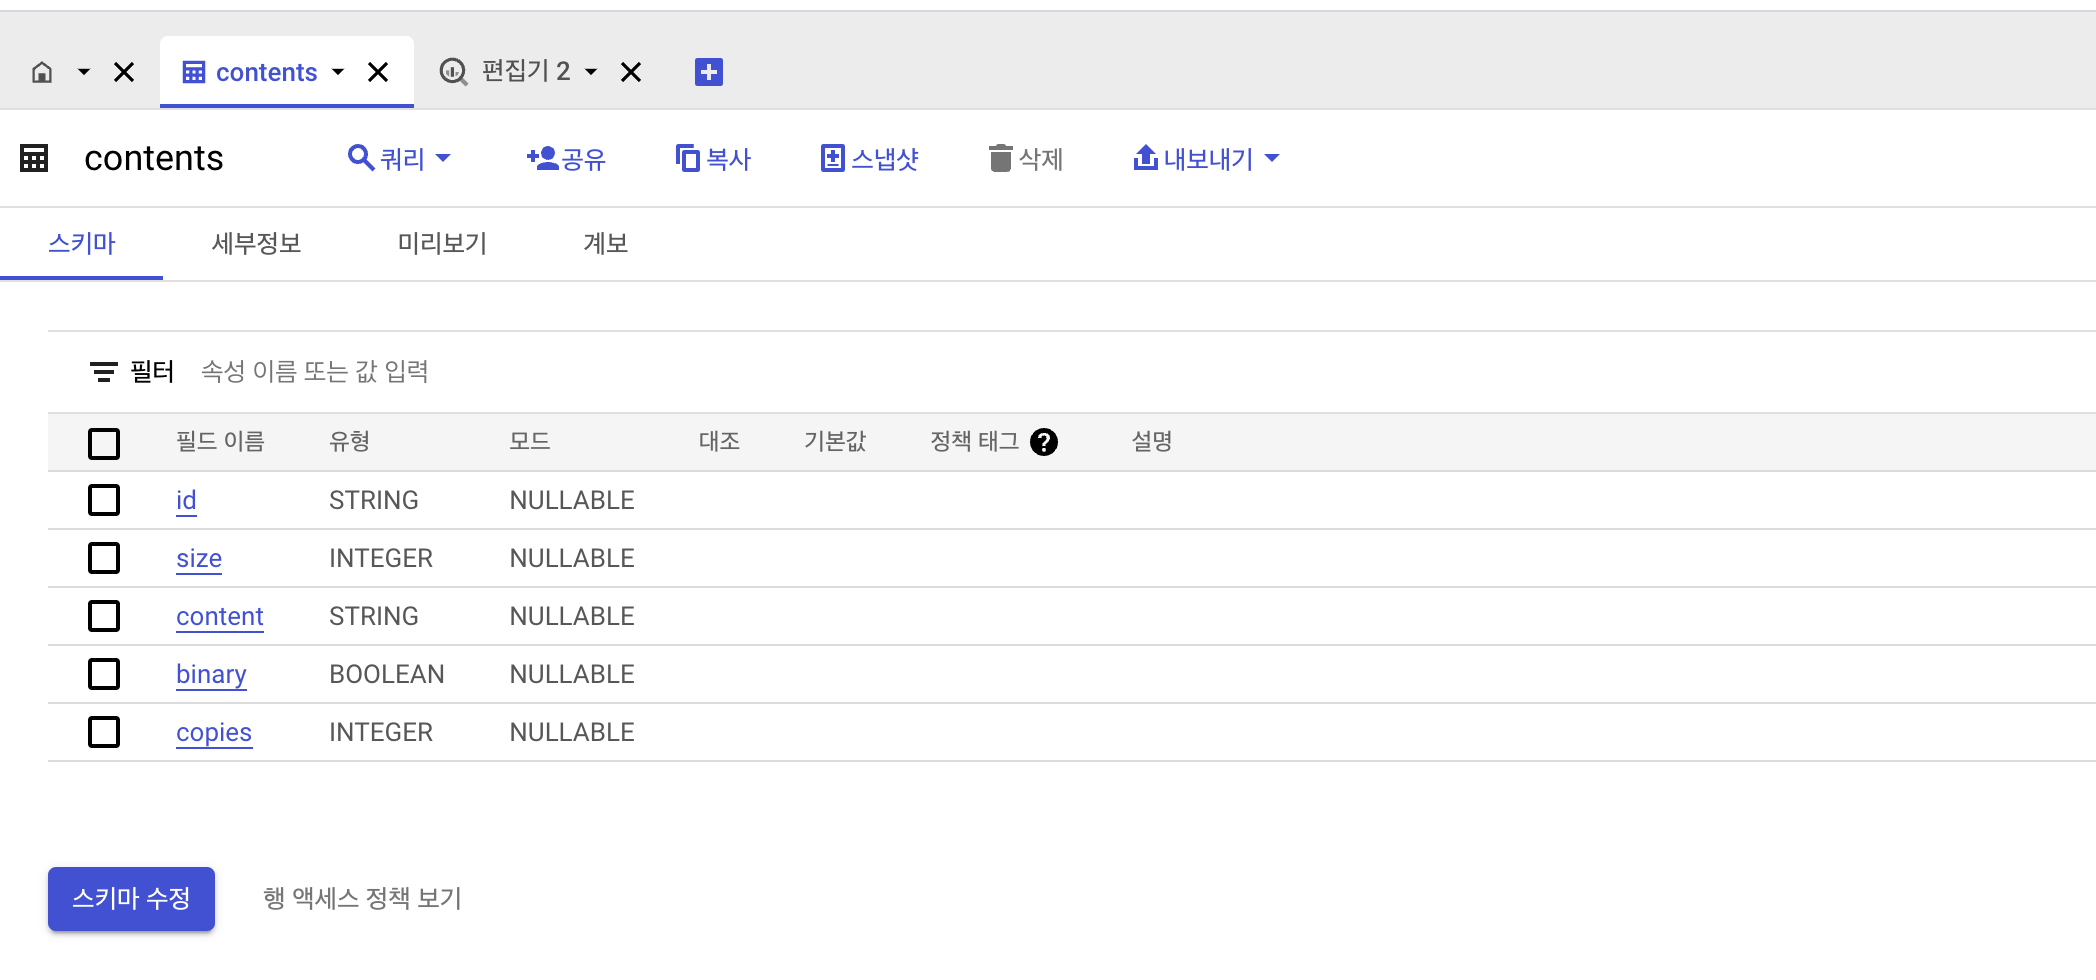

##### 사이드바: 잡음 필터링 여부


수집 단계에서 미리 원하는 데이터만 가져오도록 필터링 룰을 SQL에 적용할 수 있음
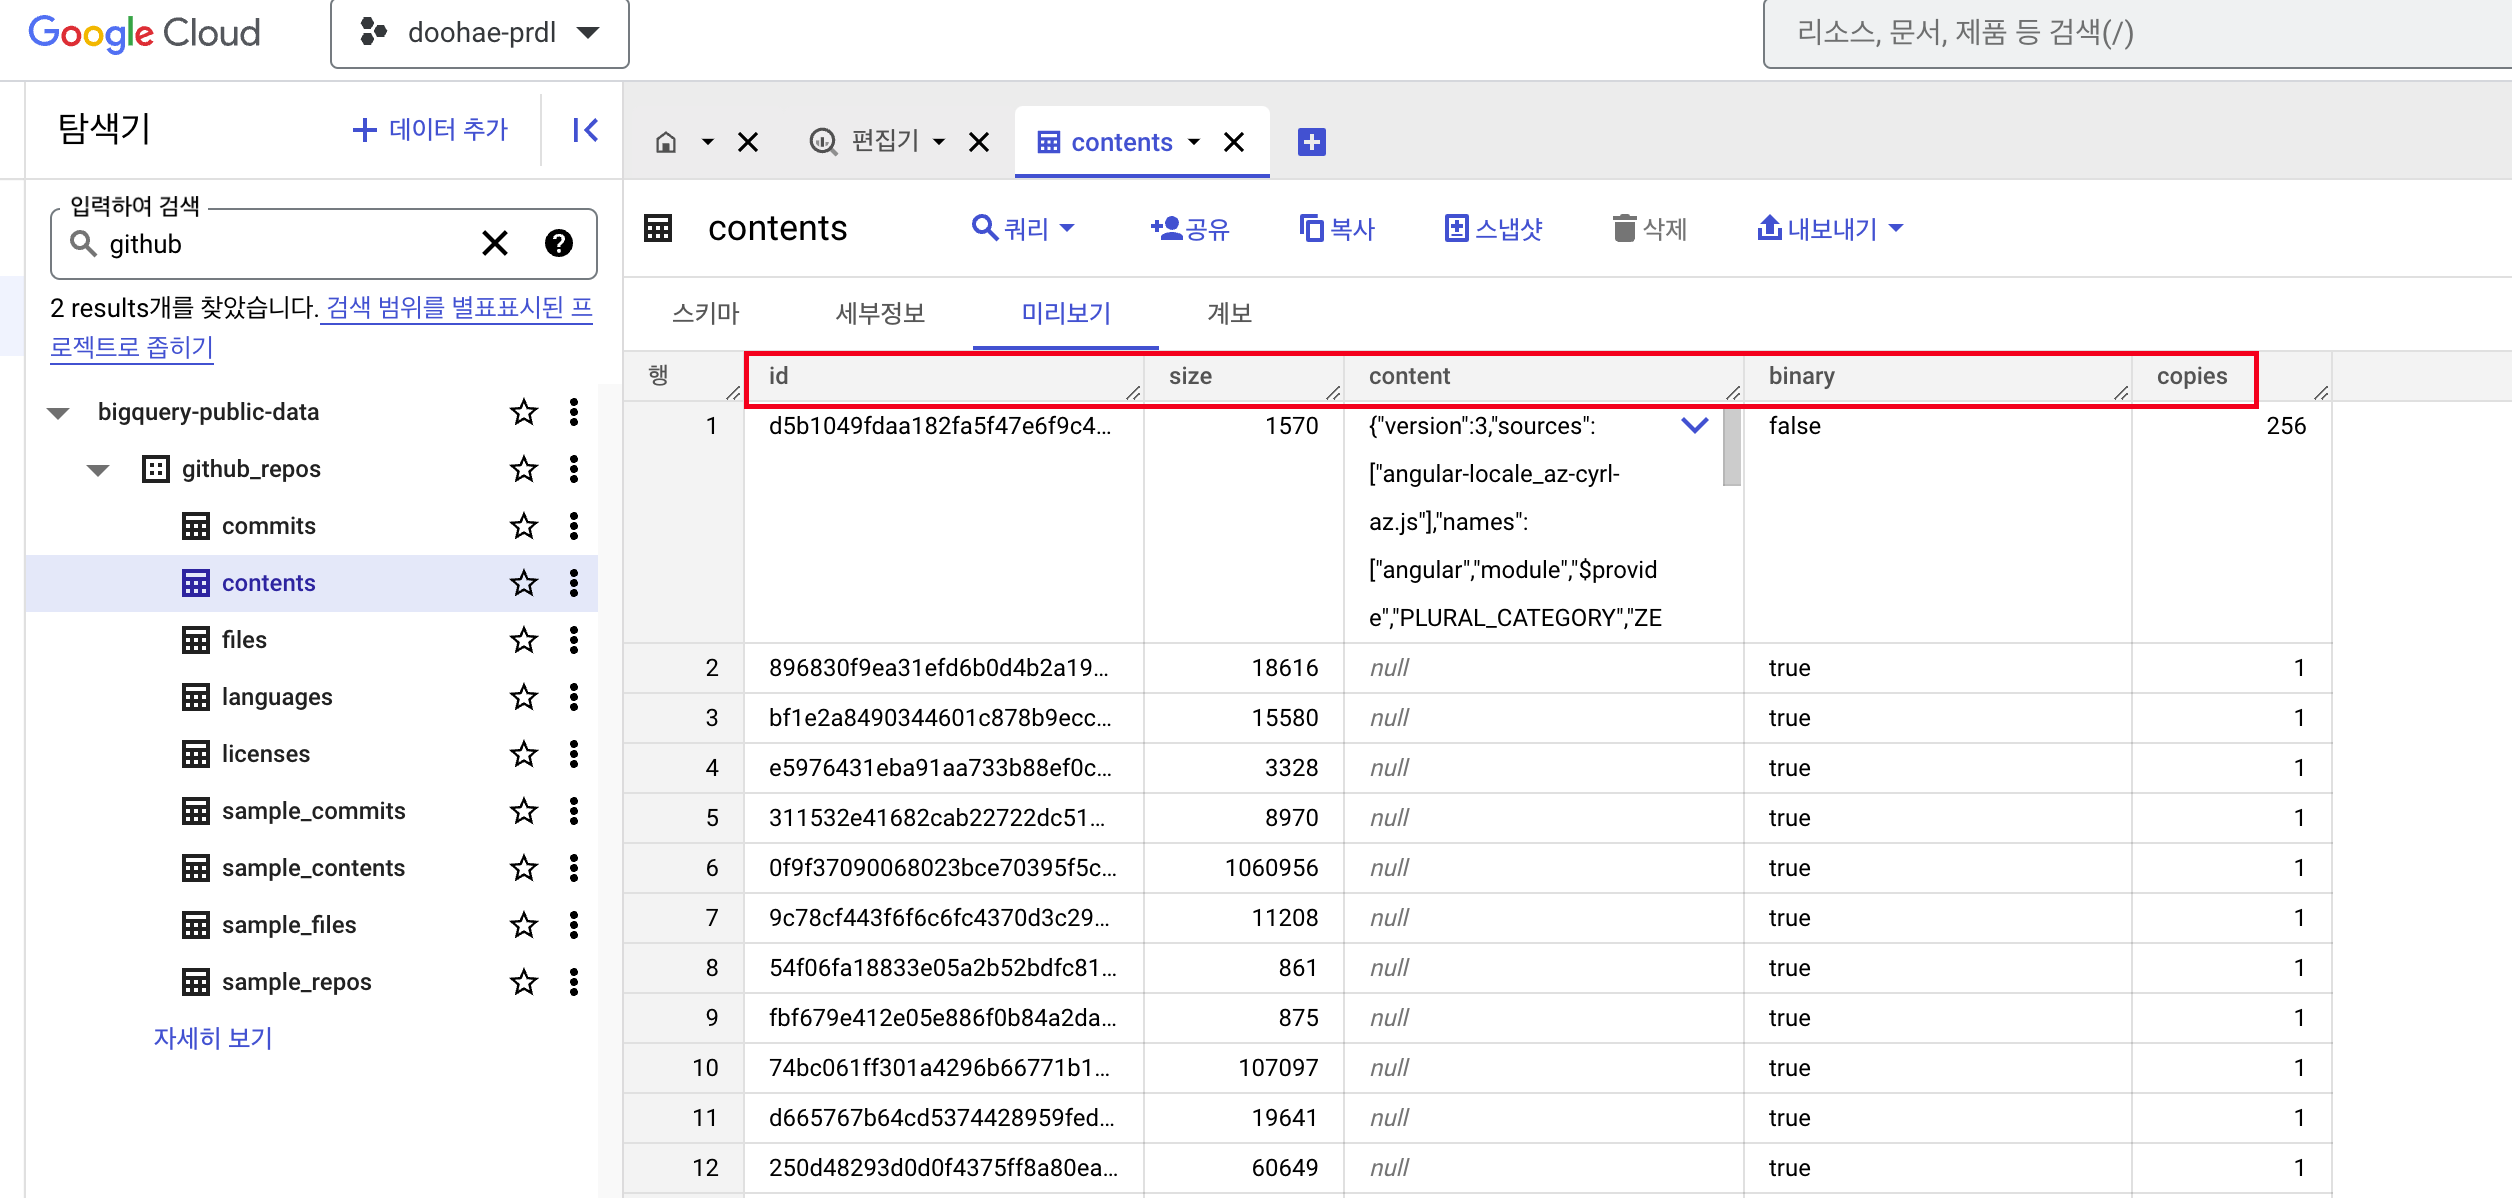

수집 이후에도 다양한 데이터를 필터링 하기 위한 프로세싱 작업을 수행할 수 있음 -> 아래 사진과 같은 데이터가 사전학습에 도움이 될까?  
code data preparation: https://github.com/huggingface/transformers/blob/main/examples/research_projects/codeparrot/scripts/preprocessing.py
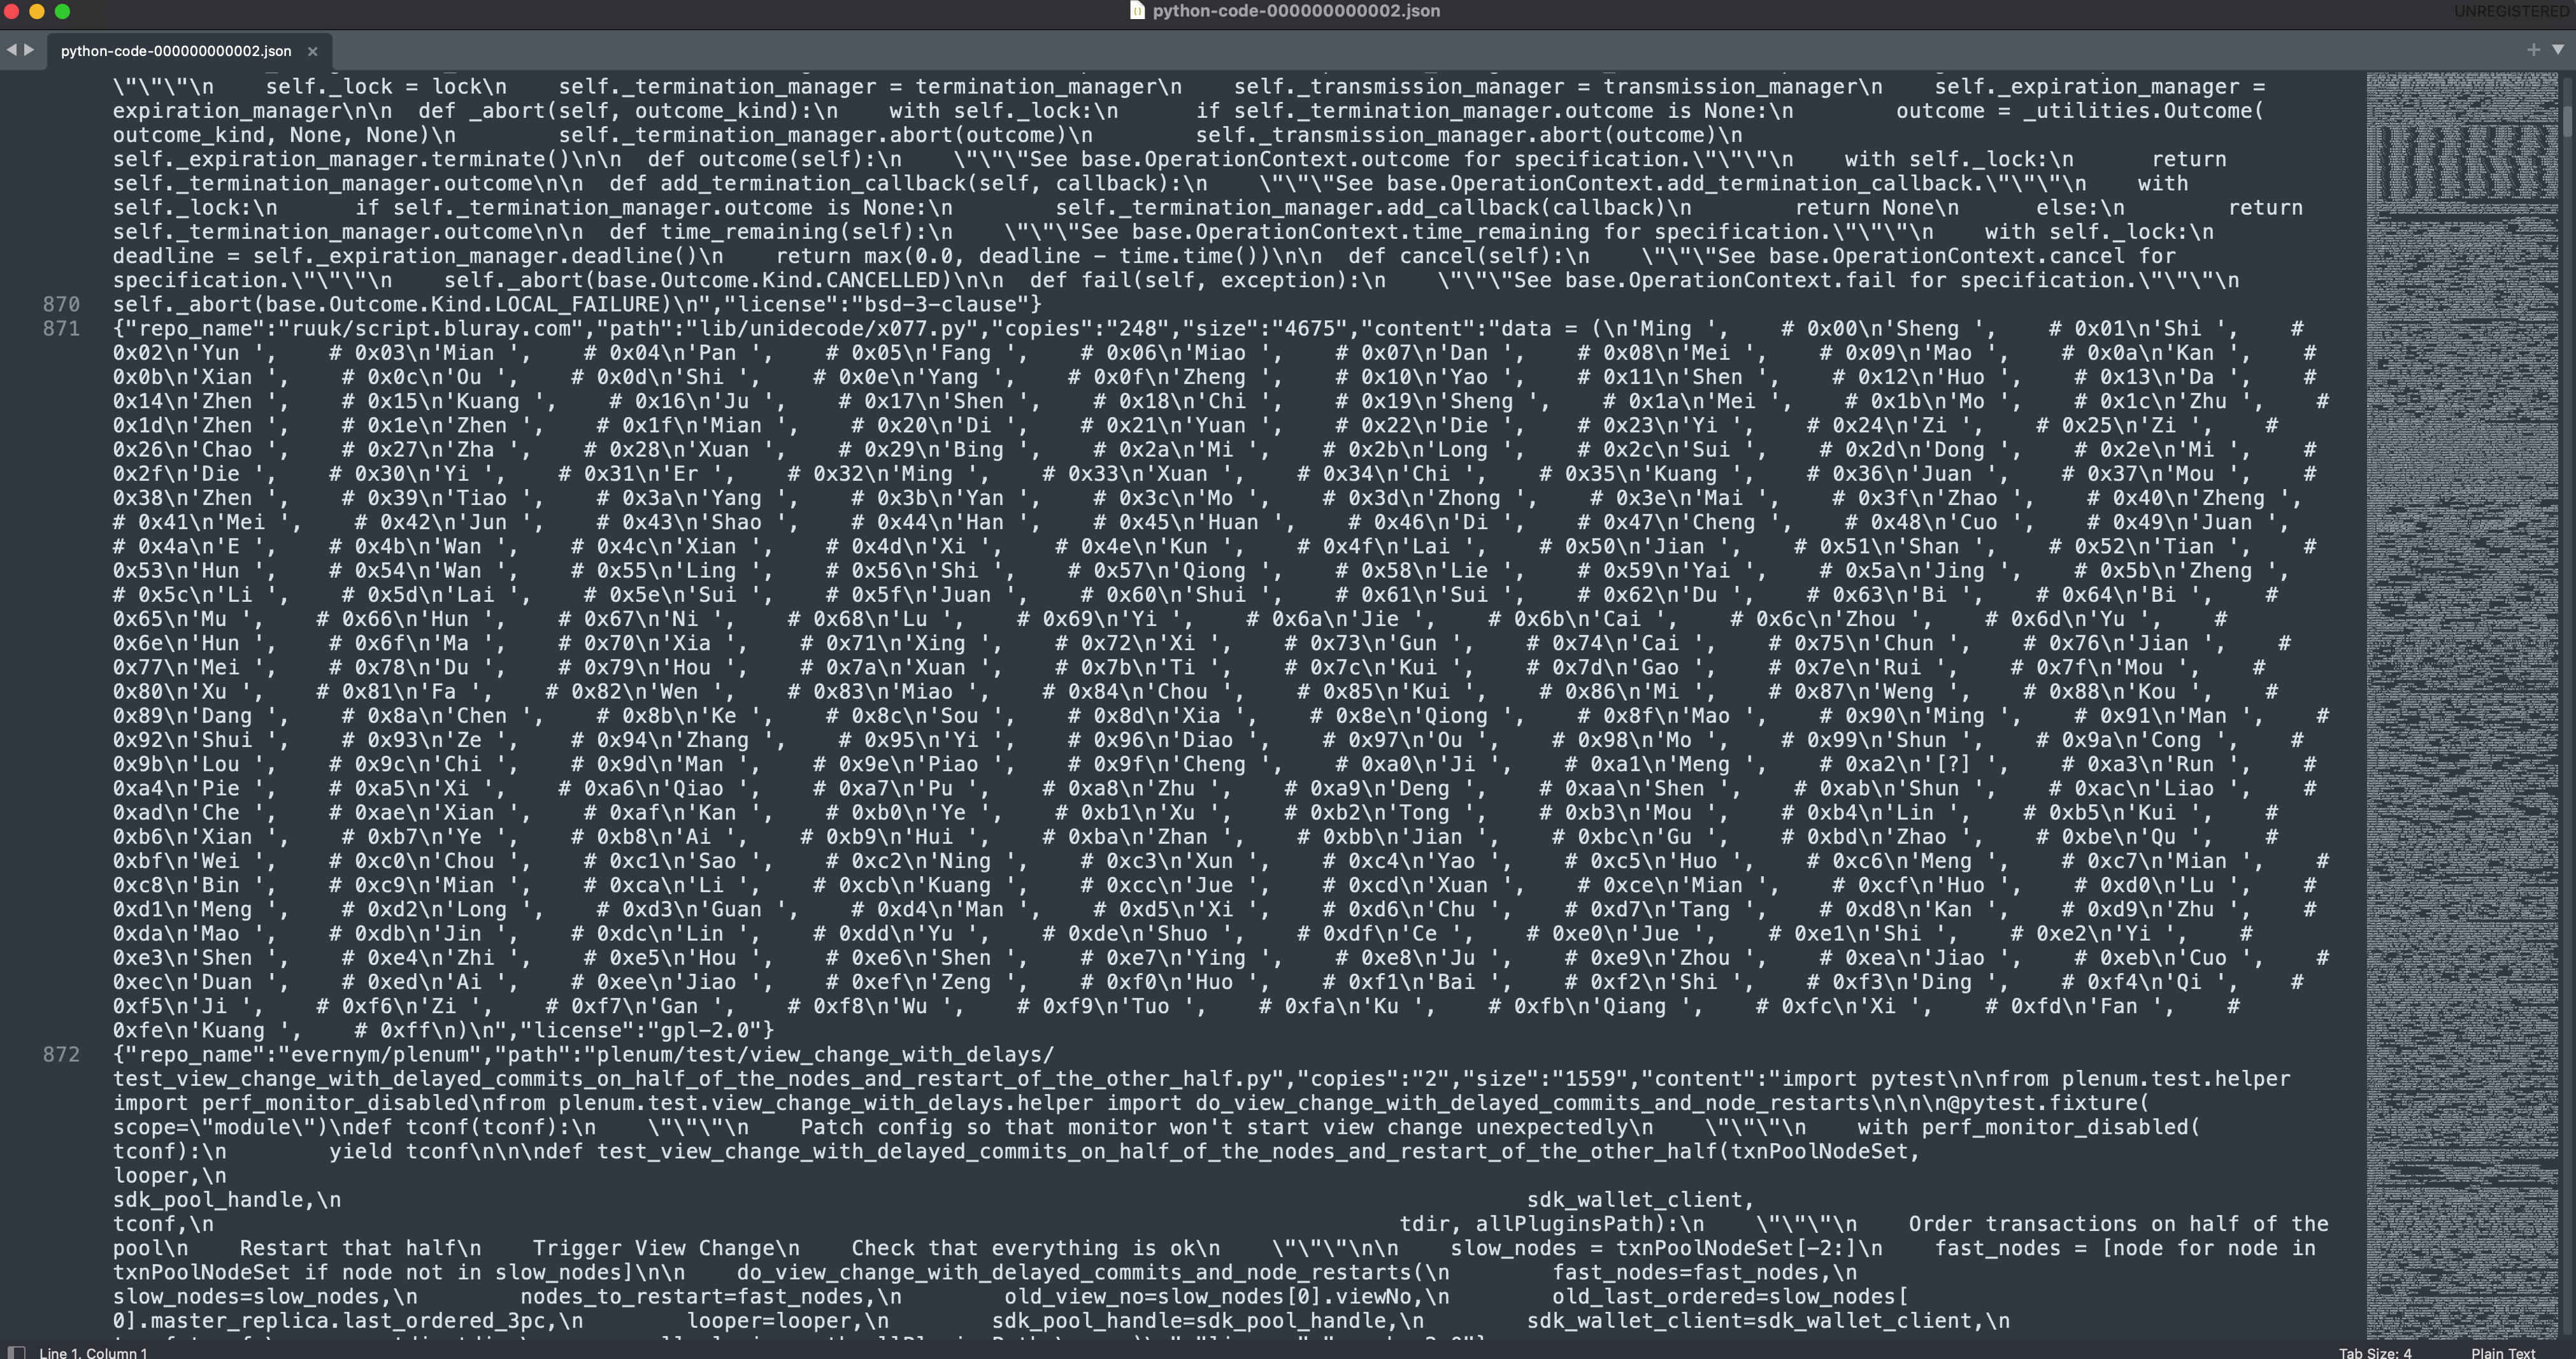

### 대용량 데이터셋 다루기

> **Note:** 다음 코드 블록은 빅쿼리 데이터셋을 `codeparrot` 폴더에 다운로드했다고 가정합니다. 압축 파일을 풀면 ~180GB 디스크 공간이 필요하기 때문에 이 단계를 건너 뛰는 것이 좋습니다. 이 코드는 예시 목적으로 쓴 것입니다. 대신 디스크 공간을 많이 사용하지 않는 스트리밍 데이터셋을 사용할 수 있습니다.

#### 메모리 매핑

> HuggingFace Dataset은 zero-copy, zero-overhead 메모리 매핑 방식이 기본적으로 활성화   
> 각 데이터셋은 메모리 내용이 바로 반영되는 하나의 파일로 디스크에 캐싱  
> 데이터셋을 메모리로 로딩하지 않고 **읽기 전용 포인터(pointer)** 를 열어 메모리 대신 이를 사용하는 방식, 하드 드라이브를 메모리의 확장으로 사용하는 방식  
> 데이터셋을 메모리에 로딩하는 방식과 로딩 속도도 비슷하면서 램을 거의 사용하지 않는 메모리 효율적인 방식  

In [ ]:
from datasets import load_dataset, DownloadConfig

# 메모리 매핑 방식의 데이터셋 객체 생성
# delete_extracted=True 옵션으로 더 이상 필요하지 않은 파일 삭제
download_config = DownloadConfig(delete_extracted=True)
dataset = load_dataset("./codeparrot", split="train",
                       download_config=download_config)

In [ ]:
import psutil, os

# 데이터셋 로드시 차지하는 램 용량 확인
print(f"Number of python files code in dataset : {len(dataset)}")
ds_size = sum(os.stat(f["filename"]).st_size for f in dataset.cache_files)
# os.stat.st_size는 바이트 단위이므로 GB로 바꿉니다
print(f"Dataset size (cache file) : {ds_size / 2**30:.2f} GB")
# Process.memory_info는 바이트 단위이므로 MB로 바꿉니다
print(f"RAM used: {psutil.Process(os.getpid()).memory_info().rss >> 20} MB")

Number of python files code in dataset : 18695559
Dataset size (cache file) : 183.68 GB
RAM memory used: 4924 MB


#### 스트리밍

> 압축된 파일을 열어 동적으로 스트리밍하여 로드하는 방식  
> 캐시가 생성되지 않음  
> 이 때 데이터셋은 IterableDataset 객체로 indexing이 가능한 형태가 아님  
> 허브에 있는 데이터도 다운받지 않고 로드할 수 있음  

> Map-style Dataset vs. IterableDataset?  
> 참고(Pytorch 공식 문서): https://pytorch.org/docs/stable/data.html#dataset-types

In [ ]:
# 스트리밍 방식의 데이터셋 객체 생성
streamed_dataset = load_dataset('./codeparrot', split="train", streaming=True)

Using custom data configuration default-cae7a1d2f0dbde67


In [ ]:
iterator = iter(streamed_dataset)

print(dataset[0] == next(iterator))
print(dataset[1] == next(iterator))

True
True


In [ ]:
remote_dataset = load_dataset('transformersbook/codeparrot', split="train",
                              streaming=True)

## 토크나이저 구축하기

아래와 같이 자주 사용하는 단어더라도 토크나이저 학습시에 빠졌다면 효율적으로 처리하지 못할 수 있음 (= 한 단어를 여러 토큰으로 처리하는 경우가 있음)

In [ ]:
from transformers import AutoTokenizer

# 인코딩->디코딩 결과를 반환하는 함수
def tok_list(tokenizer, string):
    input_ids = tokenizer(string, add_special_tokens=False)["input_ids"]
    return [tokenizer.decode(tok) for tok in input_ids]

tokenizer_T5 = AutoTokenizer.from_pretrained("t5-base")
tokenizer_camembert = AutoTokenizer.from_pretrained("camembert-base")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

In [ ]:
# 불용어 필터링이 광범위하게 적용된 T5 학습 코퍼스
print(f'"sex"에 대한 T5 토큰: {tok_list(tokenizer_T5,"sex")}')
# 프랑스어로 학습되어 흔한 영어 단어를 처리하지 못하는 CamemBERT
print(f'"being"에 대한 CamemBERT 토큰: {tok_list(tokenizer_camembert,"being")}')

T5 tokens for "sex": ['', 's', 'ex']
CamemBERT tokens for "being": ['be', 'ing']


### 토크나이저 모델
> 데이터로 훈련하는 토크나이저 파이프라인 부분 의미 -> vocab 구축의 관점에서
1. BPE: 자주 등장하는 pair끼리 병합
2. WordPiece: 코퍼스 내에서 병합되었을 때 likelihood를 가장 높이는 쌍을 병합
3. Unigram: vocab에서 서브워드(subword)가 제거 되었을 때의 loss를 기반으로 가장 악영향을 주는 subword 제거  

wikidocs: https://wikidocs.net/22592  
HuggingFace course: https://huggingface.co/course/chapter6/2?fw=pt

### 토크나이저 성능 측정하기
> 일반적으로 주어진 코퍼스를 얼마나 적은 토큰으로 처리하는지 측정
1. Subword Fertility: tokenize된 단어마다 생성되는 subword의 평균 개수 계산
2. Proportion of Continued Words: 말뭉치에서 최소 두 개 부분 토큰으로 분할된 tokenize된 단어 비율 계산
3. Coverage Metrics: tokenize된 말뭉치에서 알 수 없는 단어나 거의 사용되지 않는 토큰의 비율 계산

tokenizer fertility: http://juditacs.github.io/2019/02/19/bert-tokenization-stats.html

### 파이썬 코드를 위한 토크나이저

> 토크나이저는 Python의 GIL때문에 성능 제약이 있어서 실제로 백엔드에서는 Rust로 구현되어 있음  
> 우리가 사용하는 Python API는 이 Rust 구현체를 바인딩한 버전

In [ ]:
from transformers import AutoTokenizer

python_code = r"""def say_hello():
    print("Hello, World!")
# Print it
say_hello()
"""
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print(tokenizer(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'Ċ', 'Ġ', 'Ġ', 'Ġ', 'Ġprint', '("',
'Hello', ',', 'ĠWorld', '!"', ')', 'Ġ#', 'ĠPrint', 'Ġit', 'Ċ', 'Ċ', 'say', '_',
'hello', '()', 'Ċ']


"Ġ"는 무엇일까?
> byte-level에서 "공백"에 맵핑된 바이트  

In [ ]:
print(tokenizer.backend_tokenizer.normalizer)

None


tokenizer pipeline: https://huggingface.co/docs/tokenizers/pipeline  
> tokenizer로 encoding시에 백엔드에서 벌어지는 일들
1. normalization
2. pre-tokenization
3. model
4. post-processing

In [ ]:
# 토큰이 스트링 기준 몇 번째 인덱스에 해당하는지 알려주는 튜플 반환 -> 오프셋 매핑
print(tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(python_code))

[('def', (0, 3)), ('Ġsay', (3, 7)), ('_', (7, 8)), ('hello', (8, 13)), ('():',
(13, 16)), ('ĊĠĠĠ', (16, 20)), ('Ġprint', (20, 26)), ('("', (26, 28)), ('Hello',
(28, 33)), (',', (33, 34)), ('ĠWorld', (34, 40)), ('!")', (40, 43)), ('Ġ#', (43,
45)), ('ĠPrint', (45, 51)), ('Ġit', (51, 54)), ('Ċ', (54, 55)), ('Ċ', (55, 56)),
('say', (56, 59)), ('_', (59, 60)), ('hello', (60, 65)), ('()', (65, 67)), ('Ċ',
(67, 68))]


#### Unicode vs. Byte
- Unicode alphabet: 143,859
- Byte alphabet: 256

> byte alphabet 256개를 조합하여 utf-8로 구성된 어떠한 문자든 표현할 수 있음   
> byte-level이 가장 low-level

In [ ]:
a, e = u"a", u"€"
byte = ord(a.encode("utf-8"))
print(f'`{a}`는 단일 바이트 `{a.encode("utf-8")}`로 인코딩됩니다: {byte}')
byte = [ord(chr(i)) for i in e.encode("utf-8")]
print(f'`{e}`는 세 바이트 `{e.encode("utf-8")}`로 인코딩됩니다: {byte}')

`a` is encoded as `b'a'` with a single byte: 97
`€` is encoded as `b'\xe2\x82\xac'` with three bytes: [226, 130, 172]


In [ ]:
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode

byte_to_unicode_map = bytes_to_unicode()
unicode_to_byte_map = dict((v, k) for k, v in byte_to_unicode_map.items())
base_vocab = list(unicode_to_byte_map.keys())

print(f'기본 어휘 사전 크기: {len(base_vocab)}')
print(f'첫 번째 원소: `{base_vocab[0]}`, last element: `{base_vocab[-1]}`')

Size of our base vocabulary: 256
First element: `!`, last element: `Ń`


In [ ]:
# BPE 문자 매핑의 예
import pandas as pd
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode

byte_to_unicode_map = bytes_to_unicode()
unicode_to_byte_map = dict((v, k) for k, v in byte_to_unicode_map.items())
base_vocab = list(unicode_to_byte_map.keys())

# 바이트에 매핑되는 유니코드 문자 프린트해보기
examples = [
    ['Regular characters', '`a` and `?`', f'{ord("a")} and {ord("?")}' , f'`{byte_to_unicode_map[ord("a")]}` and `{byte_to_unicode_map[ord("?")]}`'],
    ['Nonprintable control character (carriage return)', '`U+000D`', f'13', f'`{byte_to_unicode_map[13]}`'],
    ['A space', '` `', f'{ord(" ")}', f'`{byte_to_unicode_map[ord(" ")]}`'],
    ['A nonbreakable space', '`\\xa0`', '160', f'`{byte_to_unicode_map[ord(chr(160))]}`'],
    ['A newline character', '`\\n`', '10', f'`{byte_to_unicode_map[ord(chr(10))]}`'],
]

pd.DataFrame(examples, columns = ['Description', 'Character', 'Bytes', 'Mapped bytes'])

In [ ]:
print(tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(python_code))

[('def', (0, 3)), ('Ġsay', (3, 7)), ('_', (7, 8)), ('hello', (8, 13)), ('():',
(13, 16)), ('ĊĠĠĠ', (16, 20)), ('Ġprint', (20, 26)), ('("', (26, 28)), ('Hello',
(28, 33)), (',', (33, 34)), ('ĠWorld', (34, 40)), ('!")', (40, 43)), ('Ġ#', (43,
45)), ('ĠPrint', (45, 51)), ('Ġit', (51, 54)), ('Ċ', (54, 55)), ('Ċ', (55, 56)),
('say', (56, 59)), ('_', (59, 60)), ('hello', (60, 65)), ('()', (65, 67)), ('Ċ',
(67, 68))]


In [ ]:
print(f"어휘 사전의 크기: {len(tokenizer)}")

Size of the vocabulary: 50257


In [ ]:
print(tokenizer(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'Ċ', 'Ġ', 'Ġ', 'Ġ', 'Ġprint', '("',
'Hello', ',', 'ĠWorld', '!"', ')', 'Ġ#', 'ĠPrint', 'Ġit', 'Ċ', 'Ċ', 'say', '_',
'hello', '()', 'Ċ']


### 토크나이저 훈련하기

In [ ]:
# 토크나이저 사전에서 길이가 긴 단어들 확인
tokens = sorted(tokenizer.vocab.items(), key=lambda x: len(x[0]), reverse=True)
print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[:8]]);

['ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ', '
=================================================================', '
----------------------------------------------------------------',
'................................................................',
'ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ',
'----------------------------------------------------------------',
'================================================================',
'________________________________________________________________']


In [ ]:
# 토크나이저 사전에서 드물게 나타나는 단어들 확인 (뒤쪽 인덱스)
tokens = sorted(tokenizer.vocab.items(), key=lambda x: x[1], reverse=True)
print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[:12]]);

['<|endoftext|>', ' gazed', ' informants', ' Collider', ' regress', 'ominated',
' amplification', 'Compar', '…."', ' (/', 'Commission', ' Hitman']


In [ ]:
from tqdm.auto import tqdm

length = 100000
dataset_name = 'transformersbook/codeparrot-train'
dataset = load_dataset(dataset_name, split="train", streaming=True)
iter_dataset = iter(dataset)

# corpus를 tokenizer trainer에 넘겨줄 iterator 구성
def batch_iterator(batch_size=10):
    for _ in tqdm(range(0, length, batch_size)):
        yield [next(iter_dataset)['content'] for _ in range(batch_size)]

# iterator를 받아 tokenizer 학습
# 일반적으로 코퍼스를 샘플링하여 (데이터 충분할 떄 1%면 충분) 토크나이저를 학습하지만
# 여기서는 별도의 sampling_ratio를 지정하지 않았음
new_tokenizer = tokenizer.train_new_from_iterator(batch_iterator(), 
                                                  vocab_size=12500,
                                                  initial_alphabet=base_vocab)

Check remote data files:   0%|          | 0/183 [00:00<?, ?it/s]

Using custom data configuration codeparrot-train-99775fd6743284b5


In [ ]:
# vocab에 등록된 단어들 확인
tokens = sorted(new_tokenizer.vocab.items(), key=lambda x: x[1], reverse=False)
print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[257:280]]);

['  ', '    ', '   ', '        ', 'se', 'in', '       ', 're', 'on', 'te', '\n
', '\n        ', 'or', 'st', 'de', '\n   ', 'th', 'le', ' =', 'lf', 'self',
'me', 'al']


In [ ]:
# vocab에 등록된 단어들 확인
print([f'{new_tokenizer.convert_tokens_to_string(t)}' for t,_ in tokens[-12:]]);

[' capt', ' embedded', ' regarding', 'Bundle', '355', ' recv', ' dmp', ' vault',
' Mongo', ' possibly', 'implementation', 'Matches']


In [ ]:
# 토크나이즈 확인
# ĊĠĠĠ와 같이 multiple whitespace도 잘 처리하는 모습
print(new_tokenizer(python_code).tokens())

['def', 'Ġs', 'ay', '_', 'hello', '():', 'ĊĠĠĠ', 'Ġprint', '("', 'Hello', ',',
'ĠWor', 'ld', '!")', 'Ġ#', 'ĠPrint', 'Ġit', 'Ċ', 'Ċ', 's', 'ay', '_', 'hello',
'()', 'Ċ']


In [ ]:
import keyword

# Python의 예약어 (e.g. def, class, True, False 등등)가
# vocab에 있는지 없는지 확인
print(f'파이썬 전체 예약어 개수: {len(keyword.kwlist)}')
for keyw in keyword.kwlist:
    if keyw not in new_tokenizer.vocab:
        print(f'예약어 `{keyw}`는 어휘 사전에 없습니다.')

There are in total 35 Python keywords.
No, keyword `await` is not in the vocabulary
No, keyword `finally` is not in the vocabulary
No, keyword `nonlocal` is not in the vocabulary


In [ ]:
# 더 큰 vocab size의 토크나이저를 학습하고 관찰
length = 200000

new_tokenizer_larger = tokenizer.train_new_from_iterator(batch_iterator(),
    vocab_size=32768, initial_alphabet=base_vocab)

100%|██████████| 200/200 [05:08<00:00,  1.54s/it]


In [ ]:
tokens = sorted(new_tokenizer_larger.vocab.items(), key=lambda x: x[1],
                reverse=False)
print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[-12:]]);

['lineEdit', 'spik', ' BC', 'pective', 'OTA', 'theus', 'FLUSH', ' excutils',
'00000002', ' DIVISION', 'CursorPosition', ' InfoBar']


In [ ]:
print(new_tokenizer_larger(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'ĊĠĠĠ', 'Ġprint', '("', 'Hello', ',',
'ĠWorld', '!")', 'Ġ#', 'ĠPrint', 'Ġit', 'Ċ', 'Ċ', 'say', '_', 'hello', '()',
'Ċ']


In [ ]:
for keyw in keyword.kwlist:
    if keyw not in new_tokenizer_larger.vocab:
        print(f'예약어 `{keyw}`는 어휘 사전에 없습니다.')

No, keyword `nonlocal` is not in the vocabulary


### 허브에 사용자 정의 토크나이저 저장하기

In [ ]:
model_ckpt = "codeparrot"
org = "transformersbook"
new_tokenizer_larger.push_to_hub(model_ckpt, organization=org)

Cloning https://huggingface.co/transformersbook/codeparrot into local empty directory.


'https://huggingface.co/transformersbook/codeparrot/commit/1c284adaa3cc9f8635ae7e3377bd3739f48bc09a'

In [ ]:
reloaded_tokenizer = AutoTokenizer.from_pretrained(org + "/" + model_ckpt)
print(reloaded_tokenizer(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'ĊĠĠĠ', 'Ġprint', '("', 'Hello', ',',
'ĠWorld', '!")', 'Ġ#', 'ĠPrint', 'Ġit', 'Ċ', 'Ċ', 'say', '_', 'hello', '()',
'Ċ']


In [ ]:
new_tokenizer.push_to_hub(model_ckpt+ "-small-vocabulary", organization=org)

Cloning https://huggingface.co/transformersbook/codeparrot-small-vocabulary into local empty directory.


'https://huggingface.co/transformersbook/codeparrot-small-vocabulary/commit/0b37bed9956d95d0b79ada169f6a281e15c63381'

## 밑바닥부터 모델을 훈련하기

### 사전 훈련 목표 (Pre-training Objective)
> Language Model이 언어를 학습하는 방식을 정의  
> 일반적으로 아키텍쳐별로 다른 objective를 갖고 학습함

<img alt="Code snippet" caption="An example of a Python function that could be found in our dataset" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter10_code-snippet.png?raw=1" id="code-snippet"/>

#### 코잘 언어 모델링 (Causal Language Modeling)
> 일반적으로 GPT계열의 decoder 모델에서 다음에 올 token을 예측하는 방식으로 학습  
> 생성 모델에 적합한 사전 학습 방식

<img alt="CLM pretraining" caption="In causal language modeling, the future tokens are masked and the model has to predict them; typically a decoder model such as GPT is used for such a task" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter10_pretraining-clm.png?raw=1" id="pretraining-clm"/>

#### 마스크드 언어 모델링 (Masked Language Modeling)
> BERT계열의 Encoder 모델에서 중간에 마스킹된 토큰이 무엇인지 예측하는 방식으로 학습  
> 언어 이해 태스크 (language understanding)에 적합한 사전 학습 방식

<img alt="MLM pretraining" caption="In masked language modeling some of the input tokens are either masked or replaced, and the model's task is to predict the original tokens; this is the architecture underlying the encoder branch of transformer models" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter10_pretraining-mlm.png?raw=1" id="pretraining-mlm"/>

#### 시퀀스-투-시퀀스 훈련 (Sequence-to-sequence Training)
> 아래 그림과 같이 pair가 되는 데이터를 이용한 학습  
> (Encoder-decoder 모델에서도 위와 같은 causal, masked language modeling objective을 많이 활용하기도 함)

<img alt="Seq2seq pretraining" caption="Using an encoder-decoder architecture for a sequence-to-sequence task where the inputs are split into comment/code pairs using heuristics: the model gets one element as input and needs to generate the other one" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter10_pretraining-seq2seq.png?raw=1" id="pretraining-seq2seq"/>

### 모델 초기화

> **NOTE**: 다음 코드 블록에서 대용량 GPT-2 체크포인트를 메모리에 로드합니다. 코랩이나 캐글 같은 플랫폼에서는 램이나 GPU 메모리가 부족하기 때문에 인스턴스가 종료될 수 있습니다.   
> 이런 경우 `config = AutoConfig.from_pretrained("gpt2", vocab_size=len(tokenizer))`로 설정을 바꾸어 작은 체크포인트를 사용하면 이 예제를 실행할 수 있습니다.

In [ ]:
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(org + "/" + model_ckpt)
# AutoModel.from_pretrained()와 다르게 학습된 체크포인트가 아닌 config만 불러옴
config = AutoConfig.from_pretrained("gpt2-xl", vocab_size=len(tokenizer))
model = AutoModelForCausalLM.from_config(config)

Downloading:   0%|          | 0.00/787 [00:00<?, ?B/s]

In [ ]:
print(f'GPT-2 (xl) 크기: {model_size(model)/1000**2:.1f}M parameters')

GPT-2 (xl) size: 1529.6M parameters


In [ ]:
model.save_pretrained("models/" + model_ckpt, push_to_hub=True,
                      organization=org)

### 데이터로더 구축하기

> 수집된 코퍼스의 길이는 모두 천차만별!  
> 온전한 코퍼스를 그대로 학습시키기 위해서는 배치화(batchify)를 할 때, 너무 긴 길이는 잘리거나 너무 짧은 길이는 패딩이 과하게 들어가는 경우 발생 (계산 비효율적)  
> 따라서, 학습시 컴퓨팅 효율을 위해 아래와 같이 코퍼스를 이어 붙여 (gpt에서 <|endoftext|>로 구분) **max_sequence_length** 길이로 자른 청크를 개별 샘플로 취급

<img alt="Preprocessing for CLM" caption="Preparing sequences of varying length for causal language modeling by concatenating several tokenized examples with an EOS token  before chunking them" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter10_preprocessing-clm.png?raw=1" id="preprocessing-clm"/>

In [ ]:
examples, total_characters, total_tokens = 500, 0, 0
dataset = load_dataset('transformersbook/codeparrot-train', split='train',
                       streaming=True)

for _, example in tqdm(zip(range(examples), iter(dataset)), total=examples):
    total_characters += len(example['content'])
    total_tokens += len(tokenizer(example['content']).tokens())

characters_per_token = total_characters / total_tokens

100%|██████████| 500/500 [00:04<00:00, 122.59it/s]


In [ ]:
print(characters_per_token)

3.6233025034779565


#### IterableDataset에서 \_\_iter\_\_() 호출 시 벌어지는 일
1. 샘플을 이어 붙인다. 이어 붙일 때 eos token 으로 구분
2. buffer size가 max_sequence_length보다 커질 때 까지 이어붙임
3. 버퍼에 있는 sample을 max_sequence_length 단위 (= chunk)로 자른다. 

#### Map-style Dataset일 때
> 일반적으로 미리 모델 max_sequence_length에 맞게 잘라둔 데이터를 갖고 학습함

In [ ]:
import torch
from torch.utils.data import IterableDataset

class ConstantLengthDataset(IterableDataset):
    
    def __init__(self, tokenizer, dataset, seq_length=1024,
                 num_of_sequences=1024, chars_per_token=3.6):
        self.tokenizer = tokenizer
        self.concat_token_id = tokenizer.eos_token_id
        self.dataset = dataset
        self.seq_length = seq_length
        # buffer는 캐릭터 단위로 읽기 때문에 미리 계산
        self.input_characters = seq_length * chars_per_token * num_of_sequences
    
    def __iter__(self):
        iterator = iter(self.dataset)
        more_examples = True
        while more_examples:
            buffer, buffer_len = [], 0
            while True:
                # 버퍼에 찬 길이가 input_character보다 길면 채우기 중단
                if buffer_len >= self.input_characters:
                    m=f"Buffer full: {buffer_len}>={self.input_characters:.0f}"
                    print(m)
                    break
                # 버퍼에 찬 길이가 input_character보다 짧으면 버퍼에 시퀀스 채우기
                try:
                    m=f"Fill buffer: {buffer_len}<{self.input_characters:.0f}"
                    print(m)
                    buffer.append(next(iterator)["content"])
                    buffer_len += len(buffer[-1])
                except StopIteration:
                    iterator = iter(self.dataset)

            # 버퍼에 찬 시퀀스를 eos token으로 구분하여 이어 붙이기
            all_token_ids = []
            tokenized_inputs = self.tokenizer(buffer, truncation=False)
            for tokenized_input in tokenized_inputs['input_ids']:
                all_token_ids.extend(tokenized_input + [self.concat_token_id])
            
            # model length만큼 잘라서 yield
            for i in range(0, len(all_token_ids), self.seq_length):
                input_ids = all_token_ids[i : i + self.seq_length]
                if len(input_ids) == self.seq_length:
                    yield torch.tensor(input_ids)

In [ ]:
shuffled_dataset = dataset.shuffle(buffer_size=100)
constant_length_dataset = ConstantLengthDataset(tokenizer, shuffled_dataset,
                                                num_of_sequences=10)
dataset_iterator = iter(constant_length_dataset)

lengths = [len(b) for _, b in zip(range(5), dataset_iterator)]
# iter() 호출마다 버퍼를 채우고 마지막에 버퍼가 모두 찼다는 메시지 띄움
print(f"시퀀스 길이: {lengths}")

Fill buffer: 0<36864
Fill buffer: 3311<36864
Fill buffer: 9590<36864
Fill buffer: 22177<36864
Fill buffer: 25530<36864
Fill buffer: 31098<36864
Fill buffer: 32232<36864
Fill buffer: 33867<36864
Buffer full: 41172>=36864
Lengths of the sequences: [1024, 1024, 1024, 1024, 1024]


### 훈련 루프 정의하기

In [ ]:
from argparse import Namespace

# 작은 모델에 해당하는 파라미터
config = {"train_batch_size": 2, # 12
          "valid_batch_size": 2, # 12
          "weight_decay": 0.1,
          "shuffle_buffer": 1000,
          "learning_rate": 2e-4, # 5e-4
          "lr_scheduler_type": "cosine",
          "num_warmup_steps": 750, # 2000
          "gradient_accumulation_steps": 16, # 1
          "max_train_steps": 50000, # 150000
          "max_eval_steps": -1,
          "seq_length": 1024,
          "seed": 1,
          "save_checkpoint_steps": 50000} # 15000

args = Namespace(**config)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import logging
import wandb

def setup_logging(project_name):
    logger = logging.getLogger(__name__)
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S", level=logging.INFO, handlers=[
        logging.FileHandler(f"log/debug_{accelerator.process_index}.log"),
        logging.StreamHandler()])
    if accelerator.is_main_process: # 로깅을 한 번만 설정합니다.
        wandb.init(project=project_name, config=args)
        run_name = wandb.run.name
        tb_writer = SummaryWriter()
        tb_writer.add_hparams(vars(args), {'0': 0})
        logger.setLevel(logging.INFO)
        datasets.utils.logging.set_verbosity_debug()
        transformers.utils.logging.set_verbosity_info()
    else:   # 서브 프로세스의 경우 에러일 때에만 로깅하도록 설정합니다.
        tb_writer = None
        run_name = ''
        logger.setLevel(logging.ERROR)
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()
    return logger, tb_writer, run_name

In [ ]:
# tensorboard와 wandb에 로그 기록할 함수 정의
def log_metrics(step, metrics):
    logger.info(f"Step {step}: {metrics}")
    if accelerator.is_main_process: # 메인 프로세스에서만 기록하도록 합니다.
        wandb.log(metrics)
        [tb_writer.add_scalar(k, v, step) for k, v in metrics.items()]

In [ ]:
from torch.utils.data.dataloader import DataLoader

# 위에서 정의한 데이터셋을 바탕으로 데이터로더 리턴하는 함수 정의
def create_dataloaders(dataset_name):
    train_data = load_dataset(dataset_name+'-train', split="train",
                              streaming=True)
    train_data = train_data.shuffle(buffer_size=args.shuffle_buffer,
                                    seed=args.seed)
    valid_data = load_dataset(dataset_name+'-valid', split="validation",
                              streaming=True)
    
    train_dataset = ConstantLengthDataset(tokenizer, train_data,
                                          seq_length=args.seq_length)
    valid_dataset = ConstantLengthDataset(tokenizer, valid_data,
                                          seq_length=args.seq_length)
    
    train_dataloader=DataLoader(train_dataset, batch_size=args.train_batch_size)
    eval_dataloader=DataLoader(valid_dataset, batch_size=args.valid_batch_size)
    return train_dataloader, eval_dataloader

Check remote data files:   0%|          | 0/183 [00:00<?, ?it/s]

Using custom data configuration codeparrot-train-938ce362e6f661b1
Using custom data configuration codeparrot-valid-29167601d8e69487


In [ ]:
# bias와 layer-norm에는 weight decay를 설정하지 않음
def get_grouped_params(model, no_decay=["bias", "LayerNorm.weight"]):
    params_with_wd, params_without_wd = [], []
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [{'params': params_with_wd, 'weight_decay': args.weight_decay},
            {'params': params_without_wd, 'weight_decay': 0.0}]

Weight Decay? (AdamW: https://hiddenbeginner.github.io/deeplearning/paperreview/2019/12/29/paper_review_AdamW.html)
<!-- 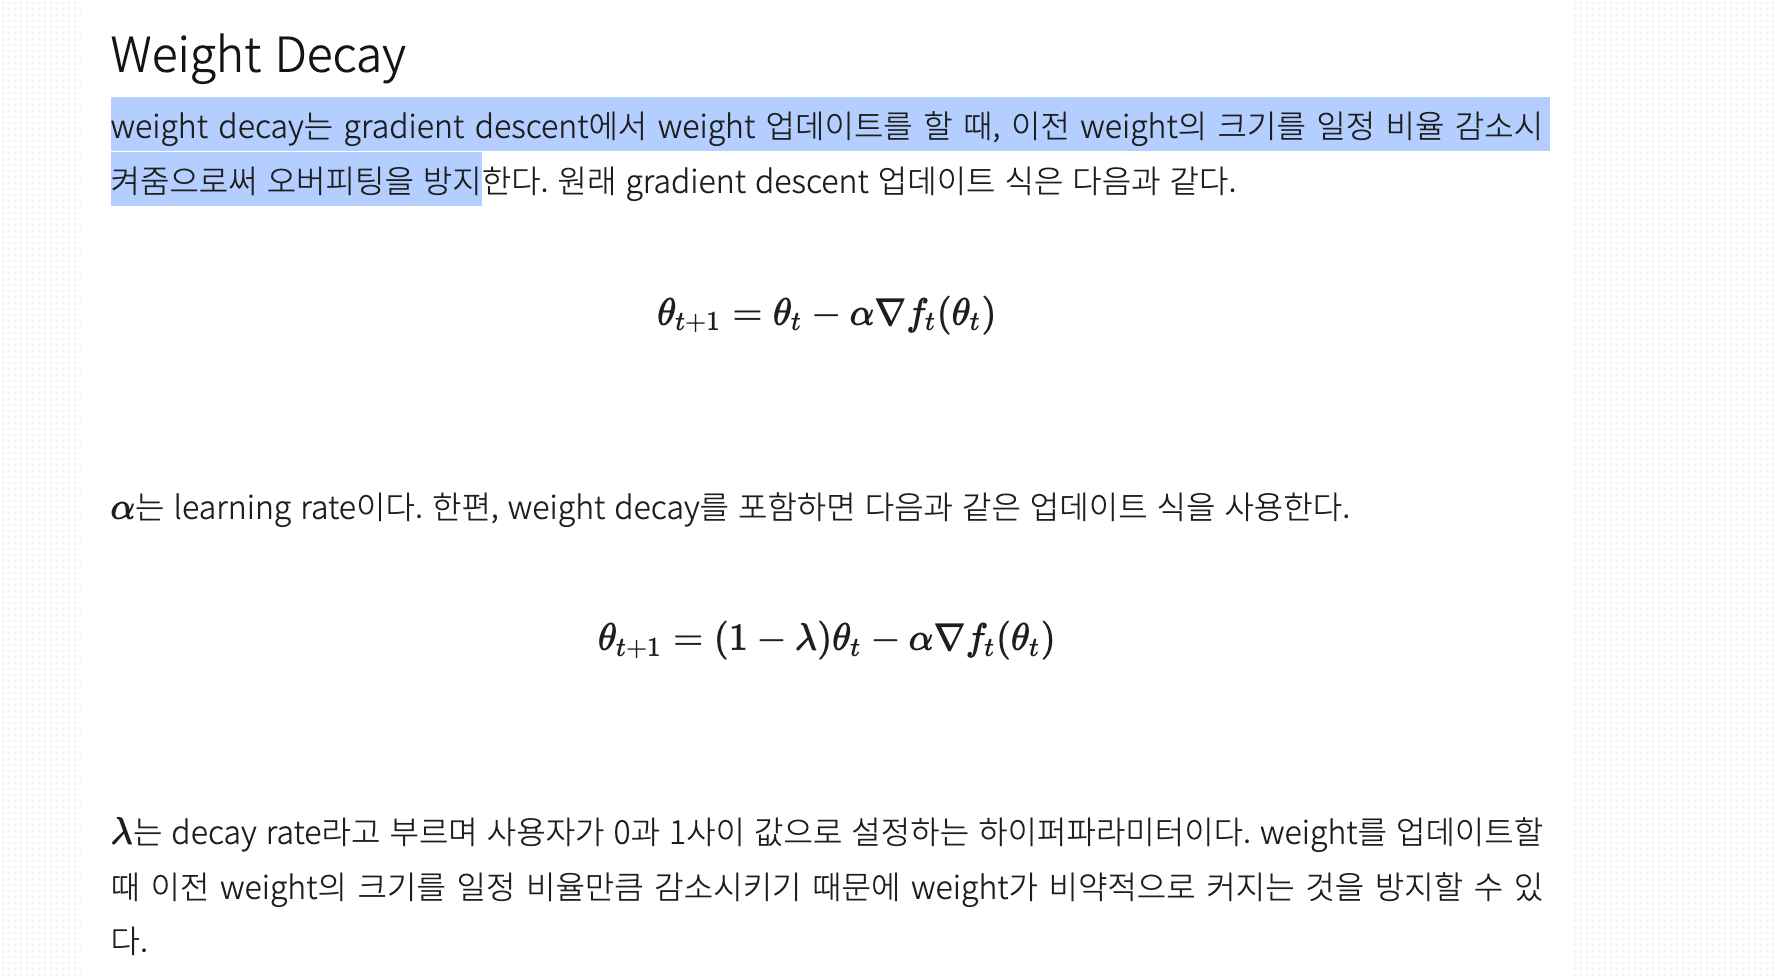
<center>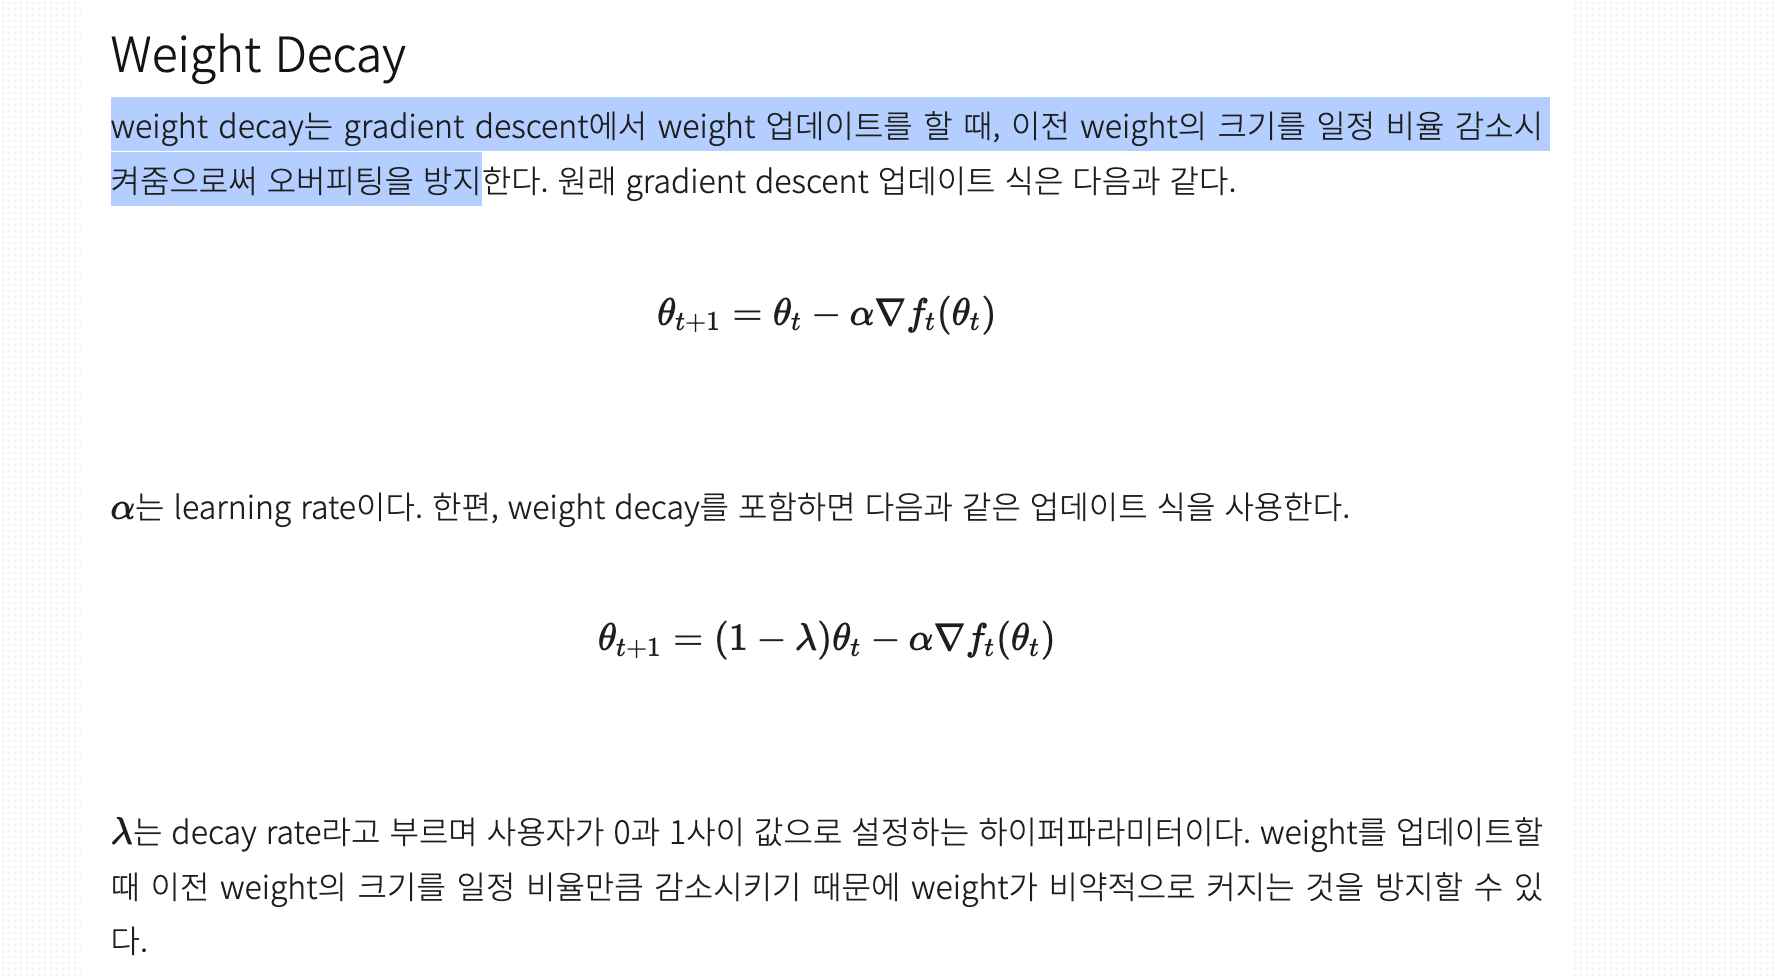</center> -->

In [ ]:
def evaluate():
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch, labels=batch)
        loss = outputs.loss.repeat(args.valid_batch_size)
        losses.append(accelerator.gather(loss))
        if args.max_eval_steps > 0 and step >= args.max_eval_steps: break
    loss = torch.mean(torch.cat(losses))
    # perplexity의 overflow가 발생하지 않을 경우에 계산
    # 모델 출력 확률 분포가 얼마나 타깃 토큰을 잘 예측하는지 측정
    try:
		perplexity = torch.exp(loss)
	except OverflowError:
		perplexity = torch.tensor(float("inf"))
    return loss.item(), perplexity.item()

In [ ]:
set_seed(args.seed)

# 엑셀러레이트
accelerator = Accelerator()
samples_per_step = accelerator.state.num_processes * args.train_batch_size

# 로깅
logger, tb_writer, run_name = setup_logging(project_name.split("/")[1])
logger.info(accelerator.state)

# 모델과 토크나이저를 로드합니다
if accelerator.is_main_process:
    hf_repo = Repository("./", clone_from=project_name, revision=run_name)
model = AutoModelForCausalLM.from_pretrained("./", gradient_checkpointing=True)
tokenizer = AutoTokenizer.from_pretrained("./")

# 데이터셋과 데이터로더를 로드합니다
train_dataloader, eval_dataloader = create_dataloaders(dataset_name)

# 옵티마이저와 학습률 스케줄러를 준비합니다
optimizer = AdamW(get_grouped_params(model), lr=args.learning_rate)
lr_scheduler = get_scheduler(name=args.lr_scheduler_type, optimizer=optimizer,
                             num_warmup_steps=args.num_warmup_steps,
                             num_training_steps=args.max_train_steps,)
def get_lr():
    return optimizer.param_groups[0]['lr']

# `accelerator`로 모든 것을 준비합니다(매개변수 순서는 중요하지 않습니다)
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader)

# 모델을 훈련합니다
model.train()
completed_steps = 0
for step, batch in enumerate(train_dataloader, start=1):
    loss = model(batch, labels=batch).loss
    log_metrics(step, {'lr': get_lr(), 'samples': step*samples_per_step,
                       'steps': completed_steps, 'loss/train': loss.item()})
    loss = loss / args.gradient_accumulation_steps
    accelerator.backward(loss)
    # accumulation step 만큼 차면 parameter update
    if step % args.gradient_accumulation_steps == 0:
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        completed_steps += 1
    if step % args.save_checkpoint_steps == 0:
        logger.info('Evaluating and saving model checkpoint')
        eval_loss, perplexity = evaluate()
        log_metrics(step, {'loss/eval': eval_loss, 'perplexity': perplexity})
        # 모든 프로세스가 여기에 도달할 때 까지 execution 중지
        accelerator.wait_for_everyone()
        # accelerator.prepare() 시에 wrapping과정에서 model에 layer가 추가되는 경우가 있는데
        # model save를 위해 이를 unwrap
        unwrapped_model = accelerator.unwrap_model(model) 
        if accelerator.is_main_process:
            unwrapped_model.save_pretrained("./")
            hf_repo.push_to_hub(commit_message=f'step {step}')
        model.train()
    if completed_steps >= args.max_train_steps:
        break

# 마지막 체크포인트를 평가하고 저장합니다
logger.info('Evaluating and saving model after training')
eval_loss, perplexity = evaluate()
log_metrics(step, {'loss/eval': eval_loss, 'perplexity': perplexity})
accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
if accelerator.is_main_process:
    unwrapped_model.save_pretrained("./")
    hf_repo.push_to_hub(commit_message=f'final model')

#### DataDistributedParallelism (DDP) 학습 메커니즘

1. 메인 프로세스에서 워커 프로세스로 모델 복사 (처음에만)
2. 메인 프로세스가 실행하는 데이터로더가 데이터 배치를 준비하고 모든 워커에 배치 전달
3. 각 프로세스에서 배치를 받고 forward & backward하여 gradient 계산
4. 각 프로세스에서 계산된 gradient를 all-reduce하여 평균값을 계산하고 이를 다시 각 워커 프로세스로 전달
5. 각 프로세스에서 각각 전달받은 all-reduce된 gradient를 이용해 모델 파라미터 업데이트 (동일한 연산을 여러번 하게 되지만 프로세스간 통신으로 모델 파라미터를 주고받지 않아도 되서 시간 효율적)
6. 2~5 반복

<img alt="DDP" caption="Illustration of the processing steps in DDP with four GPUs" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter10_ddp.png?raw=1" id="ddp"/>

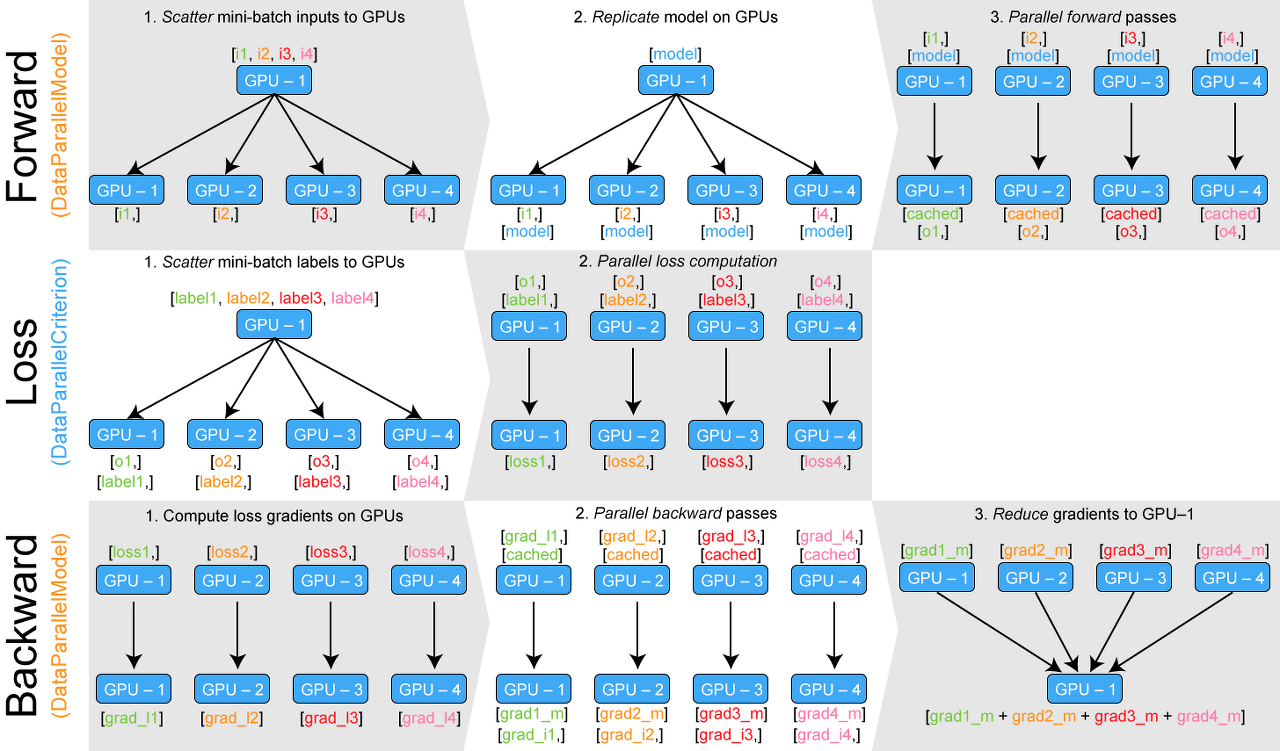

### 훈련 실행

## 결과 및 분석

In [ ]:
from transformers import pipeline, set_seed

model_ckpt = 'transformersbook/codeparrot-small'
generation = pipeline('text-generation', model=model_ckpt, device=0)

2021-10-20 18:29:01.107727: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-20 18:29:01.107759: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
import re
from transformers import set_seed 

# 생성 결과에 "class", "def", "#", "print" 등이 나오면 앞 부분만 취하도록 정의
# humaneval: https://arxiv.org/abs/2107.03374
def first_block(string):
    return re.split('\nclass|\ndef|\n#|\n@|\nprint|\nif', string)[0].rstrip()

# nucleus sampling을 이용해 주어진 prompt에 대한 다양한 생성 결과를 만들어냄
def complete_code(pipe, prompt, max_length=64, num_completions=4, seed=1):
    set_seed(seed)
    gen_kwargs = {"temperature":0.4, "top_p":0.95, "top_k":0, "num_beams":1,
                  "do_sample":True,}
    code_gens = generation(prompt, num_return_sequences=num_completions, 
                            max_length=max_length, **gen_kwargs)
    code_strings = []
    for code_gen in code_gens:
        generated_code = first_block(code_gen['generated_text'][len(prompt):])
        code_strings.append(generated_code)
    print(('\n'+'='*80 + '\n').join(code_strings))

In [ ]:
# 모델이 두 변의 길이가 주어질 때 사각형의 넓이를 구하는 코드를 잘 생성하는지 확인
prompt = '''def area_of_rectangle(a: float, b: float):
    """Return the area of the rectangle."""'''
complete_code(generation, prompt)


    return math.sqrt(a * b)

    return a * b / 2.0

    return a * b

    return a * b / a


In [ ]:
# 모델이 html에서 url을 추출하는 코드를 잘 생성하는지 확인
prompt = '''def get_urls_from_html(html):
    """Get all embedded URLs in a HTML string."""'''
complete_code(generation, prompt)


    if not html:
        return []
    return [url for url in re.findall(r'<a href="(/[^/]+/[^"]+?)">', html)]

    return [url for url in re.findall(r'<a href="(.*?)"', html)
            if url]

    return [url for url in re.findall(r'<a href="(/.*)",', html)]

    return re.findall(r'<a href="(.*?)" class="url"[^>]*>', html)


In [ ]:
import requests

# 실제 생성된 코드를 이용해 html 추출하는 함수
def get_urls_from_html(html):
    return [url for url in re.findall(r'<a href="(.*?)"', html) if url]

print(" | ".join(get_urls_from_html(requests.get('https://hf.co/').text)))

https://github.com/huggingface/transformers | /allenai | /facebook |
/asteroid-team | /google | /amazon | /speechbrain | /microsoft | /grammarly |
/models | /inference-api | /distilbert-base-uncased |
/dbmdz/bert-large-cased-finetuned-conll03-english |
https://huggingface.co/transformers | https://arxiv.org/abs/1811.06031 |
https://arxiv.org/abs/1803.10631 | https://transformer.huggingface.co/ | /coref
| https://medium.com/huggingface/distilbert-8cf3380435b5


> **NOTE**: 다음 코드 블록에서 대용량 GPT-2 체크포인트를 메모리에 로드합니다. 코랩이나 캐글 같은 플랫폼에서는 램이나 GPU 메모리가 부족하기 때문에 인스턴스가 종료될 수 있습니다. 이런 경우 `model_ckpt = "transformersbook/codeparrot-small"`로 바꾸어 작은 체크포인트를 사용하면 이 예제를 실행할 수 있습니다.

In [ ]:
model_ckpt = 'transformersbook/codeparrot'
generation = pipeline('text-generation', model=model_ckpt, device=0)

# 파이썬 내장 모듈만 이용한 함수를 numpy로 바꾸는 코드를 생성하는지 확인
prompt = '''# a function in native python:
def mean(a):
    return sum(a)/len(a)

# the same function using numpy:
import numpy as np
def mean(a):'''
complete_code(generation, prompt, max_length=64)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



    return np.mean(a)

    return np.mean(a)

    return np.mean(a)

    return np.mean(a)


In [ ]:
# 모델이 사이킷런 모델을 만드는 코드를 생성하는지 확인
prompt = '''X = np.random.randn(100, 100)
y = np.random.randint(0, 1, 100)

# fit random forest classifier with 20 estimators'''
complete_code(generation, prompt, max_length=96)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



reg = DummyRegressor()

forest = RandomForestClassifier(n_estimators=20)

forest.fit(X, y)

clf = ExtraTreesClassifier(n_estimators=100, max_features='sqrt')
clf.fit(X, y)

clf = RandomForestClassifier(n_estimators=20, n_jobs=n_jobs, random_state=1)
clf.fit(X, y)

clf = RandomForestClassifier(n_estimators=20)
clf.fit(X, y)


#### 코드 생성 모델 평가
1. 생성 결과를 ground truth와 BLEU, n-gram score 계산 (옛날 방식)
2. 생성한 코드를 실제로 실행시켜 unit test 통과 여부 확인 (OpenAI Codex)

## 결론

- BigQuery를 활용해 대규모 데이터셋 직접 구축
- Python code에 효율적인 토크나이저 학습
- Accelerate를 활용해 GPT-2를 사전 학습